# Scientific Computing - Practice sessions  : Audio command recognition by DTW and classification

**Group name:**

**Names :**

**Surnames :**

The Practice sessions will permit testing the dynamic programming algorithm (DTW) seen in Exercise session (TD) and then implement an audio recognition system for isolated words (constituting orders for drones).


These sessions are divided into 3 parts: 
- Part I: DTW and application of the TD
- Part II: Audio control word recognition system
- Part III: Comparison of dynamic programming with a classification method after data pre-processing by PCA

For **parts II and III**, you will test the audio recognition system on two sets of voices that will serve as a learning base (references) and a test base (sounds to be recognized) respectively. The list of the 13 drone commands are: *Landing, Takeoff, Takeoff, Advance, Right turn, Backward, Left turn, Right, Flip, Left, Stop, Higher, Lower and State of Emergency.*

To do this, you must per group of 2 students (number of students **MANDATORY**):
1. **Propose a study** that you will detail on a report.
For example, *influence male voices VS female voices, compare your own voices to the database, test the impact of different background noises on recognition...*];
2. Create, according to the objective of your study, your own learning base and test base from the proposed corpus and the voices and sounds you have recorded   [*audio parameters: 16 KHz, mono, 16 bits, *.wav format**];
3. Test the DTW and a classification method with pre-processing by PCA;
4. Evaluate the results; 
5. Write a pdf report presenting the study, the results by the 2 methods and your comments and conclusions on your study (Max. length: 8 pages).



In [47]:
import matplotlib.pyplot as plt
import numpy
import scipy
import sklearn
import math
import os
import noisereduce as nr
import scikitplot as skplot
import librosa

# Part I: Implementation of the dynamic programming algorithm 

1. Write a function in DTW python that implements the calculation and display of the cost matrix defined in TD. 

2. In order to easily adapt the cost calculation according to the nature of the data (and therefore the distances used), write a function for each distance (Euclidean, letters, sounds) that will appear as a parameter of the DTW function.

In [48]:
def distance_euclidean(_lhs, _rhs):
    if _lhs > _rhs:
        return _lhs - _rhs
    else:
        return _rhs - _lhs
    
def distance_dna(_lhs, _rhs):
    if _lhs == _rhs:
        return 0
    else:
        return 1

def distance_sound(_lhs, _rhs):
    if _lhs == _rhs:
        return 0
    
    if _lhs == 'U' or _rhs == 'U':
        return 1
    
    if _lhs == 'V' or _rhs == 'V':
        return 2
    
    return 1

def dtw(_x: numpy.array, _y: numpy.array, _omegas: numpy.array, _distance, _skip=numpy.inf):
    assert len(_x) > 0
    assert len(_y) > 0
    assert len(_omegas) == 3
    
    if len(_x) < len(_y):
        _x, _y = _y, _x

    _offset = len(_x) - len(_y)

    _matrix = numpy.full((len(_y), len(_x)), numpy.inf)

    # top left corner is always bound to the diagonal frame
    _matrix[0, 0] = _omegas[1] * _distance(_x[0], _y[0])

    # first row elements are always bound to the left frame
    for _i in range(1, min(len(_x), 1 + _offset + _skip)):
        _matrix[0, _i] = _matrix[0, _i - 1] + _omegas[0] * _distance(_x[_i], _y[0])

    # first column elements are always bound to the top frame
    for _j in range(1, min(len(_y), 1 + _skip)):
        _matrix[_j, 0] = _matrix[_j - 1, 0] + _omegas[2] * _distance(_x[0], _y[_j])

    # rest of the matrix
    for _j in range(1, len(_y)):
        for _i in range(max(1, _j - _skip), min(len(_x), 1 + _j + _offset + _skip)):
            _d = _distance(_x[_i], _y[_j])
            _matrix[_j, _i] = min(
                _matrix[_j, _i - 1] + _omegas[0] * _d,
                _matrix[_j - 1, _i - 1] + _omegas[1] * _d,
                _matrix[_j - 1, _i] + _omegas[2] * _d
            )

    return _matrix


def dtw_d(_x: numpy.array, _y: numpy.array, _matrix: numpy.array):
    assert len(_x) > 0
    assert len(_y) > 0
    
    if len(_x) < len(_y):
        _x, _y = _y, _x
        
    return _matrix[len(_y) - 1, len(_x) - 1] / (len(_x) + len(_y))

def dtw_path(_x: numpy.array, _y: numpy.array, _matrix: numpy.array):
    assert len(_x) > 0
    assert len(_y) > 0
    
    if len(_x) < len(_y):
        _x, _y = _y, _x

    _output = []

    _i = len(_x) - 1
    _j = len(_y) - 1
    
    _output.append((_i, _j))

    while _i != 0 and _j != 0:
        _min = min(_matrix[_j, _i - 1], _matrix[_j - 1, _i - 1], _matrix[_j - 1, _i])
        if _matrix[_j - 1, _i - 1] == _min:
            _i -= 1
            _j -= 1
        elif _matrix[_j, _i - 1] == _min:
            _i -= 1
        else:
            _j -= 1
            
        _output.append((_i, _j))
        
    while _i != 0:
        _i -= 1
        _output.append((_i, _j))
    
    while _j != 0:
        _j -= 1
        _output.append((_i, _j))
            
    return _output

#### Application to exercises 

1. Test your programs on the exercises seen in TD. 

2. Modify the local constraints, i.e. the weights according to the directions. 

3. Add the consideration of global constraints, i. e. non-calculation when the boxes are too far from the diagonal (see exercise TD DNA sequence). From which position do global constraints not change the results?

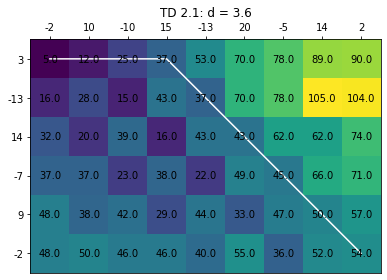

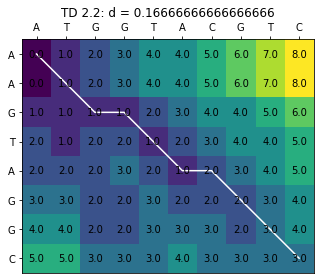

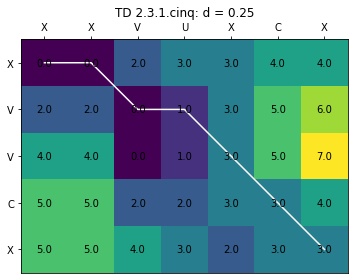

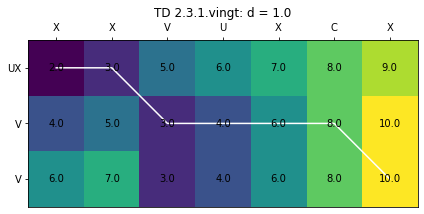

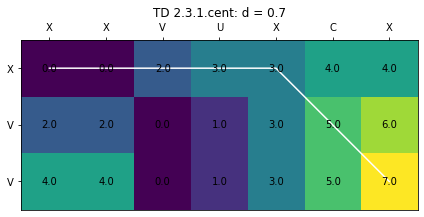

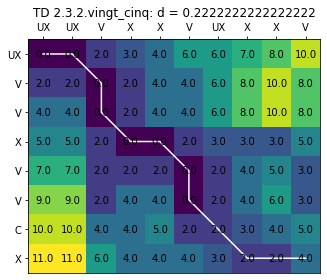

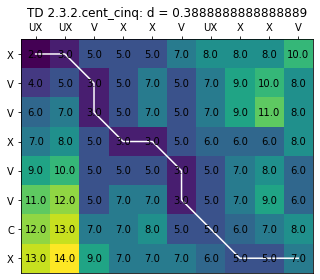

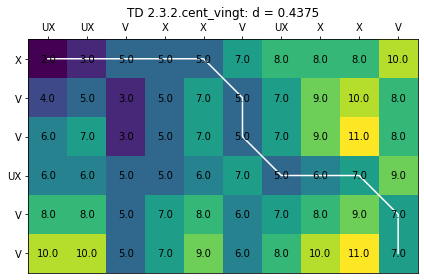

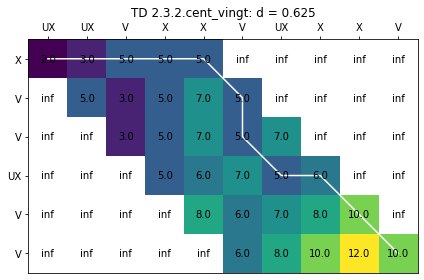

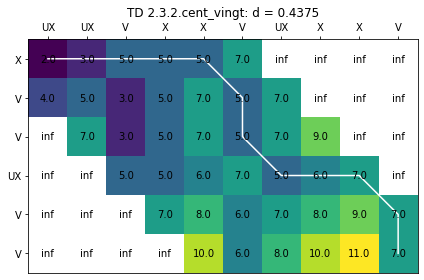

In [49]:
def show_matrix(_title: str, _x: numpy.array, _y: numpy.array, _matrix: numpy.array, _path: numpy.array):
    _figure, _axes = plt.subplots()
    _axes.imshow(_matrix)

    _axes.xaxis.tick_top()

    plt.xticks(numpy.arange(len(_x)), _x)
    plt.yticks(numpy.arange(len(_y)), _y)

    _axes.set_ylim(len(_y)-0.5, -0.5)

    for _i in range(len(_x)):
        for _j in range(len(_y)):
            _axes.text(_i, _j, _matrix[_j, _i], ha="center", va="center", color="black")
    
    _axes.set_title(_title)
    _figure.tight_layout()
    
    plt.plot([_x[0] for _x in _path], [_x[1] for _x in _path], 'w')
    
    plt.show()

def resolve_td(title, _x: numpy.array, _y: numpy.array, _o: numpy.array, _distance, skip=numpy.inf):
    _matrix = dtw(_x, _y, _o, _distance, skip)
    _path = dtw_path(_x, _y, _matrix)
    _d = dtw_d(_x, _y, _matrix)

    show_matrix(title + ": d = " + str(_d), _x, _y, _matrix, _path)

resolve_td("TD 2.1", numpy.array([-2, 10, -10, 15, -13, 20, -5, 14, 2]), numpy.array([3, -13, 14, -7, 9, -2]), numpy.array([1, 1, 1]), distance_euclidean)

resolve_td("TD 2.2", numpy.array(['A', 'T', 'G', 'G', 'T', 'A', 'C', 'G', 'T', 'C']), numpy.array(['A', 'A', 'G', 'T', 'A', 'G', 'G', 'C']), numpy.array([1, 1, 1]), distance_dna)

dtw_2_3_cinq = numpy.array(['X', 'V', 'V', 'C', 'X'])
dtw_2_3_vingt = numpy.array(['UX', 'V', 'V'])
dtw_2_3_cent = numpy.array(['X', 'V', 'V'])

resolve_td("TD 2.3.1.cinq", numpy.array(['X', 'X', 'V', 'U', 'X', 'C', 'X']), dtw_2_3_cinq, numpy.array([1, 2, 1]), distance_sound)
resolve_td("TD 2.3.1.vingt", numpy.array(['X', 'X', 'V', 'U', 'X', 'C', 'X']), dtw_2_3_vingt, numpy.array([1, 2, 1]), distance_sound)
resolve_td("TD 2.3.1.cent", numpy.array(['X', 'X', 'V', 'U', 'X', 'C', 'X']), dtw_2_3_cent, numpy.array([1, 2, 1]), distance_sound)

resolve_td("TD 2.3.2.vingt_cinq", numpy.array(['UX', 'UX', 'V', 'X', 'X', 'V', 'UX', 'X', 'X', 'V']), numpy.concatenate((dtw_2_3_vingt, dtw_2_3_cinq)), numpy.array([1, 2, 1]), distance_sound)
resolve_td("TD 2.3.2.cent_cinq", numpy.array(['UX', 'UX', 'V', 'X', 'X', 'V', 'UX', 'X', 'X', 'V']), numpy.concatenate((dtw_2_3_cent, dtw_2_3_cinq)), numpy.array([1, 2, 1]), distance_sound)
resolve_td("TD 2.3.2.cent_vingt", numpy.array(['UX', 'UX', 'V', 'X', 'X', 'V', 'UX', 'X', 'X', 'V']), numpy.concatenate((dtw_2_3_cent, dtw_2_3_vingt)), numpy.array([1, 2, 1]), distance_sound)
resolve_td("TD 2.3.2.cent_vingt", numpy.array(['UX', 'UX', 'V', 'X', 'X', 'V', 'UX', 'X', 'X', 'V']), numpy.concatenate((dtw_2_3_cent, dtw_2_3_vingt)), numpy.array([1, 2, 1]), distance_sound, 0)
resolve_td("TD 2.3.2.cent_vingt", numpy.array(['UX', 'UX', 'V', 'X', 'X', 'V', 'UX', 'X', 'X', 'V']), numpy.concatenate((dtw_2_3_cent, dtw_2_3_vingt)), numpy.array([1, 2, 1]), distance_sound, 1)

# Part II: Audio control word recognition system

On the shared space, you will find audio recordings of command words for a quadricopter drone composed of several male french speakers (noted M01...M13) and female french speakers (F01...F05).

You can thus divide all the data into learning bases that will serve as references and test bases to evaluate recognition by dynamic programming.

In [50]:
def distance_mfcc(_lhs, _rhs):
    _width = min(len(_lhs), len(_rhs))
    
    _output = 0
    
    for _i in range(0, _width):
            _output += distance_euclidean(_lhs[_i], _rhs[_i]) * distance_euclidean(_lhs[_i], _rhs[_i])
    
    return math.sqrt(_output)
    

The following lines of code allow you to transform the audio file into a matrix of parameters called MFCC (Mel Frequency Cepstral Coefficient) using the *librosa* python library. These settings are used to extract the best possible frequency voice content from the audio signal.

The output matrix is composed of as many column vectors as analysis frames. The number of lines corresponds to the size of the representative vector: here 12.


**Audio file upload:**

In [51]:
def load_norm(_path):
    _y, _sr = librosa.load(_path, sr=16000)
    _y_nr = nr.reduce_noise(audio_clip=_y, noise_clip=_y, verbose=False)
    _y_t, index = librosa.effects.trim(_y_nr, top_db=15) 
    
    _scaler = sklearn.preprocessing.StandardScaler()
    _mfcc = librosa.feature.mfcc(y=_y_t, sr=_sr, hop_length=1024, htk=True, n_mfcc=12)
    _mfcc_process = _scaler.fit_transform(_mfcc)
    
    return _y, _y_nr, _sr, _mfcc_process

class Dataset:
    TEXTS = [
        "arretetoi",
        "atterrissage",
        "avance",
        "decollage",
        "droite",
        "etatdurgence",
        "faisunflip",
        "gauche",
        "plusbas",
        "plushaut",
        "recule",
        "tournedroite",
        "tournegauche"
    ]
    
    def __init__(self, _path, _parser = lambda _name: [_name[:4], _name[4:-4], _name[-4:]]):
        self.names = []
        self.raws = []
        self.nrs = []
        self.srs = []
        self.mfccs = []
        
        _last = ""
        
        for _file in os.listdir(_path):
            _parsed_name = _parser(_file)
            if _parsed_name is not None:
                if _parsed_name[0] != _last:
                    self.names.append([None] * len(Dataset.TEXTS))
                    self.raws.append([None] * len(Dataset.TEXTS))
                    self.nrs.append([None] * len(Dataset.TEXTS))
                    self.srs.append([None] * len(Dataset.TEXTS))
                    self.mfccs.append([None] * len(Dataset.TEXTS))
                    _last = _parsed_name[0]
                try:
                    _index = Dataset.TEXTS.index(_parsed_name[1])
                    self.names[-1][_index] = _file
                    self.raws[-1][_index], self.nrs[-1][_index], self.srs[-1][_index], self.mfccs[-1][_index] = load_norm(_path + "/" + _file)
                except ValueError:
                    print("unknown command, skipping file " + _file)

dataset_without_noise_male = Dataset("../data/corpus/drone_withoutnoise", lambda name: [name[:4], name[4:-4], name[-4:]] if name[0] == "M" else None)
dataset_without_noise_female = Dataset("../data/corpus/drone_withoutnoise", lambda name: [name[:4], name[4:-4], name[-4:]] if name[0] == "F" else None)
dataset_with_noise_male = Dataset("../data/corpus/drone_noise")
dataset_custom = Dataset("../data/corpus/drone_custom")

**MFCC extraction**

In [52]:
train_male_indices = [0, 1, 2, 3, 4, 5, 6]
train_female_indices = [0, 1, 2]

# train_male = [dataset_without_noise_male.mfccs[_i] for _i in train_male_indices]
train_female = [dataset_without_noise_female.mfccs[_i] for _i in train_female_indices]

# test_male = [dataset_without_noise_male.mfccs[_i] for _i in range(0, len(dataset_without_noise_male.mfccs)) if _i not in train_male_indices]
test_female = [dataset_without_noise_female.mfccs[_i] for _i in range(0, len(dataset_without_noise_female.mfccs)) if _i not in train_female_indices]

train_male = [dataset_without_noise_male.mfccs[0]]
# train_female = [dataset_without_noise_female.mfccs[0]]

test_male = [dataset_without_noise_male.mfccs[1]]
# test_female = [dataset_without_noise_female.mfccs[0]]

**Application of DTW**

1. Carry out a study that you will detail on a report (for example, *influence male voices VS female voices, compare your own voice with the database, test the impact of different background noises on recognition...*) and create your own learning database and test database from the corpus and the voices and noises you have recorded. 

2. Apply DTW to your corpora.

**Settings for audio recordings of your personal voices:**

16 KHz, mono, 16 bits, *.wav* format

In [53]:
def test_against_train(_train: numpy.array, _test: numpy.array, _omegas: numpy.array, _distance):
    _matrices = []
    _ds = numpy.full((len(_train), len(_test), len(_train[0]), len(_test[0])), numpy.inf)
    
    if len(_train) == 0 or len(_test) == 0:
        return _matrices, _ds
    
    for _i in range(0, len(_train)):
        _matrices.append([])
        for _j in range(0, len(_test)):
            _matrices[-1].append([])
            for _k in range(0, len(_train[_i])):
                _matrices[-1][-1].append([])
                for _l in range(0, len(_test[_j])):
                    _matrices[-1][-1][-1].append(dtw(_train[_i][_k], _test[_j][_l], _omegas, _distance))
                    _ds[_i][_j][_k][_l] = dtw_d(_train[_i][_k], _test[_j][_l], _matrices[-1][-1][-1][-1])
    
    return _matrices, _ds

without_noise_male_male_matrices, without_noise_male_male_ds = test_against_train(train_male, test_male, numpy.array([2, 1, 2]), distance_mfcc)
without_noise_male_female_matrices, without_noise_male_female_ds = test_against_train(train_male, test_female, numpy.array([2, 1, 2]), distance_mfcc)
without_noise_female_male_matrices, without_noise_female_male_ds = test_against_train(train_female, test_male, numpy.array([2, 1, 2]), distance_mfcc)
without_noise_female_female_matrices, without_noise_female_female_ds = test_against_train(train_female, test_female, numpy.array([2, 1, 2]), distance_mfcc)

**Assessment of recognition**

1. Calculate the system confusion matrix (in line with the references and in column the system outputs). 
You can use the *confusion_matrix* function of the *sklearn* library.

2. Calculate the recognition score: number of well recognized files on number of tested files. 

*Verification:*
- if you use the M01 reference and test file, you must get no errors.
- if you use as M01 reference file and M02 test file, you must get two errors.

In [54]:
# skplot.metrics.plot_confusion_matrix()

def reduce_result_to_sum(_result: numpy.array):
    _output = numpy.zeros((_result.shape[1], _result.shape[2], _result.shape[3]))
    
    for _i in range(0, _result.shape[0]):
        for _j in range(0, _result.shape[1]):
            for _k in range(0, _result.shape[2]):
                for _l in range(0, _result.shape[3]):
                    _output[_j][_k][_l] += _result[_i][_j][_k][_l]
    
    return _output

def reduce_result_to_sum_squared(_result: numpy.array):
    _output = numpy.zeros((_result.shape[1], _result.shape[2], _result.shape[3]))
    
    for _i in range(0, _result.shape[0]):
        for _j in range(0, _result.shape[1]):
            for _k in range(0, _result.shape[2]):
                for _l in range(0, _result.shape[3]):
                    _output[_j][_k][_l] += _result[_i][_j][_k][_l] ** 2
    
    return _output

def reduce_result_to_min(_result: numpy.array):
    _result_transformed = numpy.empty((_result.shape[1], _result.shape[2], _result.shape[3], _result.shape[0]))
    
    for _i in range(0, _result.shape[0]):
        for _j in range(0, _result.shape[1]):
            for _k in range(0, _result.shape[2]):
                for _l in range(0, _result.shape[3]):
                    _result_transformed[_j][_k][_l][_i] = _result[_i][_j][_k][_l]
    
    _output = numpy.empty((_result.shape[1], _result.shape[2], _result.shape[3]))
    
    for _j in range(0, _result.shape[1]):
            for _k in range(0, _result.shape[2]):
                for _l in range(0, _result.shape[3]):
                    _output[_j][_k][_l] = _result_transformed[_j][_k][_l].min()
    
    return _output

def reduce_result_to_med(_result: numpy.array):
    _result_transformed = numpy.empty((_result.shape[1], _result.shape[2], _result.shape[3], _result.shape[0]))
    
    for _i in range(0, _result.shape[0]):
        for _j in range(0, _result.shape[1]):
            for _k in range(0, _result.shape[2]):
                for _l in range(0, _result.shape[3]):
                    _result_transformed[_j][_k][_l][_i] += _result[_i][_j][_k][_l]
    
    _output = numpy.empty((_result.shape[1], _result.shape[2], _result.shape[3]))
    
    for _j in range(0, _result.shape[1]):
        for _k in range(0, _result.shape[2]):
            for _l in range(0, _result.shape[3]):
                _output[_j][_k][_l] = _result_transformed[_j][_k][_l][int(len(_result_transformed[_j][_k][_l]) / 2)]
    
    return _output

without_noise_male_male_ds_sum = reduce_result_to_sum(without_noise_male_male_ds)
without_noise_male_female_ds_sum = reduce_result_to_sum(without_noise_male_female_ds)
without_noise_female_male_ds_sum = reduce_result_to_sum(without_noise_female_male_ds)
without_noise_female_female_ds_sum = reduce_result_to_sum(without_noise_female_female_ds)

without_noise_male_male_ds_sum_squared = reduce_result_to_sum_squared(without_noise_male_male_ds)
without_noise_male_female_ds_sum_squared = reduce_result_to_sum_squared(without_noise_male_female_ds)
without_noise_female_male_ds_sum_squared = reduce_result_to_sum_squared(without_noise_female_male_ds)
without_noise_female_female_ds_sum_squared = reduce_result_to_sum_squared(without_noise_female_female_ds)

without_noise_male_male_ds_min = reduce_result_to_min(without_noise_male_male_ds)
without_noise_male_female_ds_min = reduce_result_to_min(without_noise_male_female_ds)
without_noise_female_male_ds_min = reduce_result_to_min(without_noise_female_male_ds)
without_noise_female_female_ds_min = reduce_result_to_min(without_noise_female_female_ds)

without_noise_male_male_ds_med = reduce_result_to_med(without_noise_male_male_ds)
without_noise_male_female_ds_med = reduce_result_to_med(without_noise_male_female_ds)
without_noise_female_male_ds_med = reduce_result_to_med(without_noise_female_male_ds)
without_noise_female_female_ds_med = reduce_result_to_med(without_noise_female_female_ds)

def count_result(_result: numpy.array):
    _total = 0
    _valid = 0
    
    for _j in range(0, len(_result)):
        for _k in range(0, len(_result[_j])):
            _total += 1
            if _k == _result[_j][_k].argmin():
                _valid += 1
                
    return _total, _valid

without_noise_male_male_sum_total, without_noise_male_male_sum_valid = count_result(without_noise_male_male_ds_sum)
without_noise_male_female_sum_total, without_noise_male_female_sum_valid = count_result(without_noise_male_female_ds_sum)
without_noise_female_male_sum_total, without_noise_female_male_sum_valid = count_result(without_noise_female_male_ds_sum)
without_noise_female_female_sum_total, without_noise_female_female_sum_valid = count_result(without_noise_female_female_ds_sum)

without_noise_male_male_sum_squared_total, without_noise_male_male_sum_squared_valid = count_result(without_noise_male_male_ds_sum_squared)
without_noise_male_female_sum_squared_total, without_noise_male_female_sum_squared_valid = count_result(without_noise_male_female_ds_sum_squared)
without_noise_female_male_sum_squared_total, without_noise_female_male_sum_squared_valid = count_result(without_noise_female_male_ds_sum_squared)
without_noise_female_female_sum_squared_total, without_noise_female_female_sum_squared_valid = count_result(without_noise_female_female_ds_sum_squared)

without_noise_male_male_min_total, without_noise_male_male_min_valid = count_result(without_noise_male_male_ds_min)
without_noise_male_female_min_total, without_noise_male_female_min_valid = count_result(without_noise_male_female_ds_min)
without_noise_female_male_min_total, without_noise_female_male_min_valid = count_result(without_noise_female_male_ds_min)
without_noise_female_female_min_total, without_noise_female_female_min_valid = count_result(without_noise_female_female_ds_min)

without_noise_male_male_med_total, without_noise_male_male_med_valid = count_result(without_noise_male_male_ds_med)
without_noise_male_female_med_total, without_noise_male_female_med_valid = count_result(without_noise_male_female_ds_med)
without_noise_female_male_med_total, without_noise_female_male_med_valid = count_result(without_noise_female_male_ds_med)
without_noise_female_female_med_total, without_noise_female_female_med_valid = count_result(without_noise_female_female_ds_med)

print("sum of the ds")
print("male male: ", without_noise_male_male_sum_valid, " / ", without_noise_male_male_sum_total)
print("male female: ", without_noise_male_female_sum_valid, " / ", without_noise_male_female_sum_total)
print("female male: ", without_noise_female_male_sum_valid, " / ", without_noise_female_male_sum_total)
print("female female: ", without_noise_female_female_sum_valid, " / ", without_noise_female_female_sum_total)

print("")
print("sum squared of the ds")
print("male male: ", without_noise_male_male_sum_squared_valid, " / ", without_noise_male_male_sum_squared_total)
print("male female: ", without_noise_male_female_sum_squared_valid, " / ", without_noise_male_female_sum_squared_total)
print("female male: ", without_noise_female_male_sum_squared_valid, " / ", without_noise_female_male_sum_squared_total)
print("female female: ", without_noise_female_female_sum_squared_valid, " / ", without_noise_female_female_sum_squared_total)

print("")
print("min of the ds")
print("male male: ", without_noise_male_male_min_valid, " / ", without_noise_male_male_min_total)
print("male female: ", without_noise_male_female_min_valid, " / ", without_noise_male_female_min_total)
print("female male: ", without_noise_female_male_min_valid, " / ", without_noise_female_male_min_total)
print("female female: ", without_noise_female_female_min_valid, " / ", without_noise_female_female_min_total)

print("")
print("med of the ds")
print("male male: ", without_noise_male_male_med_valid, " / ", without_noise_male_male_med_total)
print("male female: ", without_noise_male_female_med_valid, " / ", without_noise_male_female_med_total)
print("female male: ", without_noise_female_male_med_valid, " / ", without_noise_female_male_med_total)
print("female female: ", without_noise_female_female_med_valid, " / ", without_noise_female_female_med_total)

sum of the ds
male male:  10  /  13
male female:  9  /  26
female male:  3  /  13
female female:  8  /  26

sum squared of the ds
male male:  10  /  13
male female:  9  /  26
female male:  3  /  13
female female:  8  /  26

min of the ds
male male:  10  /  13
male female:  9  /  26
female male:  3  /  13
female female:  7  /  26

med of the ds
male male:  2  /  13
male female:  9  /  26
female male:  2  /  13
female female:  8  /  26


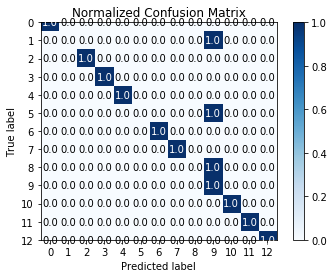

In [55]:
without_noise_male_male_predicted = []

for _i in range(0, len(without_noise_male_male_ds_min[-1])):
    without_noise_male_male_predicted.append(without_noise_male_male_ds_min[-1][_i].argmin())

skplot.metrics.plot_confusion_matrix(range(0, len(without_noise_male_male_ds_min[-1])), without_noise_male_male_predicted, normalize=True)

## Part III: Comparison of dynamic programming with a classification method after data pre-processing

In this section, we will compare the results of DTW with those of a data classification method: the k-nearest neighbors (k-nn).

We will use the functions to calculate the PCA and k-nn via the python library *scikit-learn*.


In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from mpl_toolkits.mplot3d import Axes3D

#### PCA preprocessing

To test a classification method, the size of the MFCCs must first be reduced:

1. From all the records in the learning database, perform a Principal Component Analysis (PCA) using the *PCA* function of the *scikit-learn* library and then project the test data into this new database. 

*Note:* You can also implement the PCA by
extracting the 3 eigenvectors, noted $X_1$, $X_2$, $X_3$, associated with the 3 largest eigenvalues of the
variance-covariance $\Sigma_{App}$ (by the functions *np.cov* and *np.linalg.eig*). These eigenvectors will constitute the new benchmark P. Then project the data from the learning and test database into this new database by multiplying each vector by the database $P =[X_1X_2X_3]$.

In [60]:
pca_male_train = []
for _i in range(0, len(train_male)):
    pca_male_train.append([])
    for _j in range(0, len(train_male[_i])):
        pca_male_train[-1].append(sklearn.decomposition.PCA(n_components=min(train_male[_i][_j].shape)))
        pca_male_train[-1][-1].fit(train_male[_i][_j])

pca_male_test = []
for _i in range(0, len(test_male)):
    pca_male_test.append([])
    for _j in range(0, len(test_male[_i])):
        pca_male_test[-1].append(sklearn.decomposition.PCA(n_components=min(test_male[_i][_j].shape)))
        pca_male_test[-1][-1].fit(test_male[_i][_j])

def pca_test_against_train(_train: numpy.array, _test: numpy.array, _omegas: numpy.array, _distance):
    _matrices = []
    _ds = numpy.full((len(_train), len(_test), len(_train[0]), len(_test[0])), numpy.inf)
    
    if len(_train) == 0 or len(_test) == 0:
        return _matrices, _ds
    
    for _i in range(0, len(_train)):
        _matrices.append([])
        for _j in range(0, len(_test)):
            _matrices[-1].append([])
            for _k in range(0, len(_train[_i])):
                _matrices[-1][-1].append([])
                for _l in range(0, len(_test[_j])):
                    _matrices[-1][-1][-1].append(dtw(_train[_i][_k].singular_values_, _test[_j][_l].singular_values_, _omegas, _distance))
                    _ds[_i][_j][_k][_l] = dtw_d(_train[_i][_k].singular_values_, _test[_j][_l].singular_values_, _matrices[-1][-1][-1][-1])
    
    return _matrices, _ds

pca_without_noise_male_male_matrices, pca_without_noise_male_male_ds = pca_test_against_train(pca_male_train, pca_male_test, numpy.array([2, 1, 2]), distance_euclidean)

# print(pca.explained_variance_ratio_)  
# print(pca.singular_values_)  

pca_without_noise_male_male_ds_sum = reduce_result_to_sum(pca_without_noise_male_male_ds)
pca_without_noise_male_male_ds_sum_squared = reduce_result_to_sum_squared(pca_without_noise_male_male_ds)
pca_without_noise_male_male_ds_min = reduce_result_to_min(pca_without_noise_male_male_ds)
pca_without_noise_male_male_ds_med = reduce_result_to_med(pca_without_noise_male_male_ds)

pca_without_noise_male_male_sum_total, pca_without_noise_male_male_sum_valid = count_result(pca_without_noise_male_male_ds_sum)
pca_without_noise_male_male_sum_squared_total, pca_without_noise_male_male_sum_squared_valid = count_result(pca_without_noise_male_male_ds_sum_squared)
pca_without_noise_male_male_min_total, pca_without_noise_male_male_min_valid = count_result(pca_without_noise_male_male_ds_min)
pca_without_noise_male_male_med_total, pca_without_noise_male_male_med_valid = count_result(pca_without_noise_male_male_ds_med)

print("sum of the ds")
print("male male: ", pca_without_noise_male_male_sum_valid, " / ", pca_without_noise_male_male_sum_total)
print("")
print("sum squared of the ds")
print("male male: ", pca_without_noise_male_male_sum_squared_valid, " / ", pca_without_noise_male_male_sum_squared_total)
print("")
print("min of the ds")
print("male male: ", pca_without_noise_male_male_min_valid, " / ", pca_without_noise_male_male_min_total)
print("")
print("med of the ds")
print("male male: ", pca_without_noise_male_male_med_valid, " / ", pca_without_noise_male_male_med_total)


# print(pca.explained_variance_ratio_)  
# print(pca.singular_values_)  

sum of the ds
male male:  6  /  13

sum squared of the ds
male male:  6  /  13

min of the ds
male male:  6  /  13

med of the ds
male male:  6  /  13


#### Classification by k nearest neighbors

In artificial intelligence, the k nearest neighbor method (*k-nn*) is a supervised method. In this context, there is a learning database of "label-data" pairs. To estimate the output associated with a new input $x$, the $k$ nearest neighbor  method consists of taking into account (in the same way) the $k$ learning samples whose input is closest to the new input $x$, according to a distance to be defined. The associated algorithm and an example are given below.

<img src="files/knn.jpg" width="700" height="500" >

<img src="files/kppv.png" width="300" height="300" >

**Example of classification by k-nn.** The test sample (green circle) must be classified either in the first
class of blue squares, or in the second class of red triangles. 
If k = 3 (full circle), it is assigned to the second class because there are 2 triangles and only 1 square inside the inner circle. 
If k = 5 (dotted circle), it is assigned to the first class (3 squares against 2 triangles inside the outer circle)


1. Using the *KNeighborsClassifier* function of the *sklearn.neighbors library*, perform a classification by k-nn on the learning and test basis you have predefined (take $k=1$).

2. Evaluate the k-nn method by calculating the confusion matrix and the recognition rate.

3. Change the value of $k$ for k-nn. Do you improve recognition scores?

4. Compare your results with those of DTW.